In [1]:
import pandas as pd
import numpy as np


import plotly.express as px
import plotly as plt



In [2]:
#reading dataset

df = pd.read_csv('Corpusfakebr/pre-processed.csv')
df.head(10)

,index,label,preprocessed_news
0,0,fake,katia abreu diz vai colocar expulsao moldura n...
1,1,fake,ray peita bolsonaro conservador fake entrevist...
2,2,fake,reinaldo azevedo desmascarado policia federal ...
3,3,fake,relatorio assustador bndes mostra dinheiro pub...
4,4,fake,radialista americano fala sobre pt vendem ilus...
5,5,fake,willian waack continuara internado sirio liban...
6,6,fake,problema cardiaco tira william waack jornal gl...
7,7,fake,edir macedo podera disputar eleicoes presidenc...
8,8,fake,boechat sobre lula alma pode ser honesta gover...
9,9,fake,pt diz lula nao dinheiro sobreviver chama moro...


In [3]:

df.drop(df.columns[0], axis=1, inplace=True)
df.head(10)

,label,preprocessed_news
0,fake,katia abreu diz vai colocar expulsao moldura n...
1,fake,ray peita bolsonaro conservador fake entrevist...
2,fake,reinaldo azevedo desmascarado policia federal ...
3,fake,relatorio assustador bndes mostra dinheiro pub...
4,fake,radialista americano fala sobre pt vendem ilus...
5,fake,willian waack continuara internado sirio liban...
6,fake,problema cardiaco tira william waack jornal gl...
7,fake,edir macedo podera disputar eleicoes presidenc...
8,fake,boechat sobre lula alma pode ser honesta gover...
9,fake,pt diz lula nao dinheiro sobreviver chama moro...


In [4]:
from sklearn.preprocessing import LabelEncoder

# Cria um objeto LabelEncoder
le = LabelEncoder()

# Treinando o codificador de rótulos, transformando o fake  em 0  true em 1
df['label'] = le.fit_transform(df['label'])


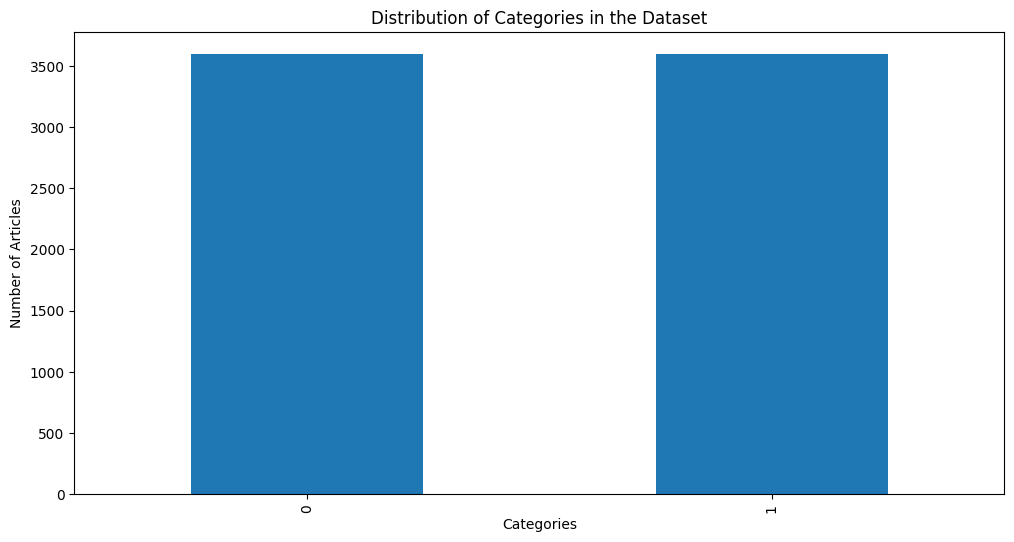

label
0    3600
1    3600
Name: count, dtype: int64


In [5]:
import pandas as pd
import matplotlib.pyplot as plt

# Conta quantos elementos (notícias) temos para cada categoria
category_counts = df['label'].value_counts()

# Plota a distribuição das categorias
plt.figure(figsize=(12, 6))
category_counts.plot(kind='bar')
plt.xlabel('Categories')
plt.ylabel('Number of Articles')
plt.title('Distribution of Categories in the Dataset')
plt.show()
print(category_counts)

In [2]:
import string
import spacy
import unicodedata
from tqdm import tqdm
import pandas as pd
import numpy as np

# Habilita o suporte do tqdm para métodos de progressão do pandas (como progress_apply)
# Com isso, é possível ver barras de progresso em operções feitas no Pandas
tqdm.pandas()

# Carrega o modelo de linguagem 'pt_core_news_lg' do spaCy para processamento de texto em português
# Desabilita os componentes 'parser' e 'ner', já que não são necessários para a lematização
spacy_nlp_model = spacy.load("pt_core_news_lg", disable=["parser", "ner"])

def preprocess_data(df, text_column):
    """
    Realiza o pré-processamento dos dados de texto em um DataFrame do Pandas.
    Remove pontuação, números e palavras comuns (stop words), converte para mínusculas, 
    remove acentos e símbolos diversos, e aplica lematização.
    """
    
    # Cria uma tabela de tradução que mapeia cada caractere de pontuação do módulo `string.punctuation` 
    # para `None` (ou seja, remove-os do texto).
    print("Removendo pontuação...")
    translator = str.maketrans('', '', string.punctuation) # Só usamos o terceiro parâmetro, que mapeia ocorrências de string.punctuation para None
    df[text_column] = df[text_column].progress_apply(lambda x: x.translate(translator))
    
    print("Removendo números...")
    translator = str.maketrans('', '', string.digits)
    df[text_column] = df[text_column].progress_apply(lambda x: x.translate(translator))
    
    print("Removendo acentos e símbolos diversos...")
    def remove_accents_and_symbols(text):
        try:
            # Normaliza a string para a forma NFKD e mantém apenas caracteres que não são diacríticos
            # nem combinam caracteres com diacríticos
            return ''.join(c for c in unicodedata.normalize('NFKD', text) if not unicodedata.combining(c) and unicodedata.category(c) != 'Mn')
        except TypeError:
            # Se não for possível normalizar um caractere, retorna uma string vazia
            return ''

    # Aplica a função 'remove_accents_and_symbols' na coluna 'text_column'
    df[text_column] = df[text_column].progress_apply(lambda x: remove_accents_and_symbols(x))
    
    print("Convertendo para minúsculas...")
    df[text_column] = df[text_column].progress_apply(lambda x: x.lower())

    print("Computando Lematização...")
    def lemmatize_text(doc):
        return [token.lemma_ for token in doc if not token.is_stop]

    n_chunks = 10  # Ajuste esse valor de acordo com o tamanho da base de dados e a memória disponível no sistema
    chunks = np.array_split(df, n_chunks) # Divide o dataframe em várias partes

    processed_chunks = []
    for i, chunk in enumerate(chunks):
        print(f"Processando segmento {i + 1} de {n_chunks}")
        processed_chunk = chunk.copy() # Cria uma cópia para realizar o processamento
        
        #  Aplica a função 'lemmatize_text' a cada documento processado pelo spaCy (usando 'spacy_nlp_model.pipe') e
        # atribui os resultados (uma lista de palavras lematizadas) à coluna 'text_column' do DataFrame 'processed_chunk'.
        # O tqdm é utilizado para exibir uma barra de progresso durante o processamento dos documentos.
        processed_chunk[text_column] = [lemmatize_text(doc) for doc in tqdm(spacy_nlp_model.pipe(chunk[text_column].astype(str), batch_size=100, disable=['parser', 'ner']), total=len(chunk[text_column]))]

        # Junta as partes em uma lista, para formar o dataframe final
        processed_chunks.append(processed_chunk)

    concatenated_df = pd.concat(processed_chunks) # Concatenar os DataFrames processados
    df[text_column] = concatenated_df[text_column] # Atribuir a coluna 'data' processada de volta ao dataframe original
    
    print("Remover tokens com espaços vazios...")
    df['preprocessed_news'] = df['preprocessed_news'].progress_apply(lambda x:  [token for token in x if token.strip()])

2023-08-31 19:07:55.996685: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-08-31 19:07:57.606660: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-08-31 19:07:57.617553: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-08-31 19:08:01.848113: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [7]:
preprocess_data(df, 'preprocessed_news') # Realiza o pré-processamento

Removendo pontuação...


100%|███████████████████████████████████| 7200/7200 [00:00<00:00, 130970.82it/s]


Removendo números...


100%|███████████████████████████████████| 7200/7200 [00:00<00:00, 120839.46it/s]


Removendo acentos e símbolos diversos...


100%|█████████████████████████████████████| 7200/7200 [00:04<00:00, 1651.15it/s]


Convertendo para minúsculas...


100%|███████████████████████████████████| 7200/7200 [00:00<00:00, 183175.16it/s]


Computando Lematização...
Processando segmento 1 de 10


100%|████████████████████████████████████████| 720/720 [00:05<00:00, 133.28it/s]


Processando segmento 2 de 10


100%|████████████████████████████████████████| 720/720 [00:03<00:00, 217.28it/s]


Processando segmento 3 de 10


100%|████████████████████████████████████████| 720/720 [00:03<00:00, 209.31it/s]


Processando segmento 4 de 10


100%|████████████████████████████████████████| 720/720 [00:04<00:00, 165.81it/s]


Processando segmento 5 de 10


100%|████████████████████████████████████████| 720/720 [00:05<00:00, 130.73it/s]


Processando segmento 6 de 10


100%|█████████████████████████████████████████| 720/720 [00:30<00:00, 23.95it/s]


Processando segmento 7 de 10


100%|█████████████████████████████████████████| 720/720 [00:19<00:00, 37.06it/s]


Processando segmento 8 de 10


100%|█████████████████████████████████████████| 720/720 [00:27<00:00, 26.51it/s]


Processando segmento 9 de 10


100%|█████████████████████████████████████████| 720/720 [00:26<00:00, 27.46it/s]


Processando segmento 10 de 10


100%|█████████████████████████████████████████| 720/720 [00:27<00:00, 25.82it/s]


Remover tokens com espaços vazios...


100%|█████████████████████████████████████| 7200/7200 [00:01<00:00, 3826.09it/s]


In [8]:
# Salvar em formato pickle
df.to_pickle("df.pkl")

In [3]:
import pandas as pd

# Carregar dataframe salvo em formato pickle
df = pd.read_pickle("df.pkl")

Treinando modelo Word2Vec

In [4]:
# Importar a classe Word2Vec da biblioteca gensim, que permite criar e treinar modelos de incorporação de palavras (word embeddings) usando o algoritmo Word2Vec
from gensim.models import Word2Vec

# Importar a classe CallbackAny2Vec da biblioteca gensim, que fornece uma base para criar funções de retorno de chamada (callbacks) personalizadas 
# durante o treinamento de modelos Word2Vec (ou outros modelos baseados em Any2Vec)
from gensim.models.callbacks import CallbackAny2Vec

In [6]:
class SimpleTextCallback(CallbackAny2Vec):
    def __init__(self, total_epochs):
        self.epoch = 0  # Inicializa o contador de épocas
        self.total_epochs = total_epochs  # Armazena o número total de épocas para exibição

    def on_epoch_end(self, model):
        self.epoch += 1  # Incrementa o contador de épocas
        print(f"Época {self.epoch} de {self.total_epochs}...") 

In [4]:
# Converte a coluna 'data' do DataFrame em uma lista e armazena na variável preprocessed_articles, para ser usada no word2vec
preprocessed_articles = df['preprocessed_news'].tolist()

In [7]:
# Instancia o modelo Word2Vec com os seguintes parâmetros:
# vector_size=100: Dimensão do vetor de palavras gerado
# window=5: Tamanho da janela de contexto ao redor de cada palavra
# min_count=1: Ignora palavras com frequência total menor que 1
# workers=4: Número de threads a serem usadas para treinar o modelo
word2vec_model = Word2Vec(vector_size=100, window=5, min_count=1, workers=4) #Se adicionar sg=0, muda pra CBOW

# Constrói o vocabulário com base nos artigos pré-processados
word2vec_model.build_vocab(preprocessed_articles)

# Define o número total de épocas para o treinamento do modelo
total_epochs = 10

# Instancia o callback que exibe o progresso do treinamento após cada época
callback = SimpleTextCallback(total_epochs)

# Treina o modelo Word2Vec nos artigos pré-processados, utilizando o número total de exemplos e épocas definidos
word2vec_model.train(preprocessed_articles, total_examples=word2vec_model.corpus_count, 
                     epochs=total_epochs, callbacks=[callback])

Época 1 de 10...
Época 2 de 10...
Época 3 de 10...
Época 4 de 10...
Época 5 de 10...
Época 6 de 10...
Época 7 de 10...
Época 8 de 10...
Época 9 de 10...
Época 10 de 10...


(22671460, 23303880)

In [14]:
# Salva o modelo Word2Vec para um arquivo
word2vec_model.save("word2vec_model.model")

In [5]:
from gensim.models import Word2Vec

# Carrega o modelo Word2Vec para um arquivo
word2vec_model = Word2Vec.load("word2vec_model.model")

In [6]:
# Encontra palavras mais similares de acordo com a palavra alvo
word2vec_model.wv.most_similar('mulher')

[('homossexual', 0.6224873065948486),
 ('domestico', 0.6213985085487366),
 ('homem', 0.6118832230567932),
 ('maes', 0.5969564318656921),
 ('engravidar', 0.59104984998703),
 ('crianco', 0.577748715877533),
 ('crianca', 0.568626344203949),
 ('mulherr', 0.5553452968597412),
 ('sexual', 0.5536457300186157),
 ('idoso', 0.5514804124832153)]

Treinamento da Stacked LSTM
A Stacked LSTM é uma extensão da Vanilla LSTM que permite a criação de redes neurais mais profundas, com duas ou mais camadas LSTM. Com isso, é possível extrair features mais complexas e capturar padrões mais sutis nos dados. A principal vantagem da Stacked LSTM é sua capacidade de lidar com tarefas de processamento de linguagem natural mais complexas, mas ela também pode sofrer de problemas ligados a gradientes.

BiLSTM
A BiLSTM (Bidirectional LSTM) é um tipo de rede neural que usa duas LSTMs, uma que processa a sequência de entrada na ordem normal e outra que processa a sequência na ordem inversa. A principal vantagem da BiLSTM é que ela pode capturar informações contextuais tanto do passado quanto do futuro, o que é importante para muitas tarefas de processamento de linguagem natural, como a análise de sentimento e a identificação de entidades nomeadas. No entanto, a BiLSTM é computacionalmente mais complexa do que a Vanilla LSTM e a Stacked LSTM, o que pode tornar seu treinamento mais demorado e exigir mais recursos computacionais.